## Семинар 1 "Полносвязные нейронные сети"

ФИО: Усцов Артем Алексеевич, ML-21  
Дата: 12 сентября 2022  

В этом задании вам предстоит реализовать проход "вперед" для полносвязной нейронной сети. В дальнейшем мы реализуем процедуру обучения и научим сеть распознавать рукописные цифры.

На первой лекции мы познакомились с тем, что такое нейронные сети и изучили три слоя — линейный, сигмоида и SoftMax. Из этих слоев можно составлять глубокие архитектуры и обучать их при помощи градиентного спуска. Чтобы конструировать сложные архитектуры, можно реализовать каждый тип слоя как отдельный "кирпичик" и затем собирать полную архитектуру как конструктор. Это мы и попробуем сделать на первом и втором семинарах.

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции: forward, которая будет применять функцию, реализуемую слоем, к входной матрице и backward, которая будет вычислять градиенты и step, которая будет обновлять веса. Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов, а d — размерность каждого объекта.

<img src=backprop.pdf width=400/>

Функция forward будет вычислять по $x$ значение $y$, backward — по $\frac{\partial L}{\partial y}$ вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$.

Важным требованием к реализации является векторизация всех слоев: все операции должны быть сведены к матричным, не должно быть циклов. Это значительно уменьшает временные затраты.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

### Часть 1: Линейный слой


Приведем пример вычисления градиентов для линейного слоя: $y = Wx$, $x \in \mathbb{R}^{K \times n}$, $y \in \mathbb{R}^{K \times n}$, $W \in \mathbb{R}^{n \times m}$, где $K$ — число объектов.

Рассмотрим $L$ как функцию от выходов нейронной сети: $L = L(y_{11}, y_{12}, \dots)$

$$y_{kt} = (Wx)_{kt} = \sum_{z=1}^{n} x_{kz}W_{zt}$$

$$\frac{\partial L}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial y_{kt}}{\partial x_{ij}} = \sum_{kt} \frac{\partial L}{\partial y_{kt}}\frac{\partial \sum_z x_{kz}w_{zt}}{\partial x_{ij}}= \sum_{t} \frac{\partial L}{\partial y_{it}}\frac{\partial w_{jt}}{\partial x_{ij}}$$

$$\frac{\partial{L}}{\partial x} = \frac{\partial{L}}{\partial y}W^T$$

In [2]:
class Linear:
    def __init__(self, input_size, output_size):
        '''
        Creates weights and biases for linear layer.
        Dimention of inputs is *input_size*, of output: *output_size*.
        '''   
        #### YOUR CODE HERE
        #### Create weights, initialize them with samples from N(0, 0.1).
        self.W = np.random.randn(input_size, output_size) * 0.1
        self.b = np.zeros(output_size)
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, input_size).
        Returns output of size (N, output_size).
        Hint: You may need to store X for backward pass
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.X = X
        self.Y = X @ self.W + self.b
        return self.Y
    
    def backward(self, dLdy):
        '''
        1. Compute dLdw and dLdx.
        2. Store dLdw for step() call
        3. Return dLdx
        '''
        #### YOUR CODE HERE
        self.dLdW = self.X.T.dot(dLdy)
        self.dLdb = dLdy.sum(0)
        dLdx = dLdy @ self.W.T
        
        return dLdx
    
    def step(self, learning_rate):
        '''
        1. Apply gradient dLdw to network:
        w <- w - l*dLdw
        '''
        self.W -= self.dLdW * learning_rate
        self.b -= self.dLdb * learning_rate

### Часть 2: Численный градиент

Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

In [3]:
EPS = 1e-6
def check_gradient(func, X, gradient):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X)
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    #### YOUR CODE HERE
    grad_X = np.zeros(X.shape)
    for i in range(grad_X.shape[0]):
        for j in range(grad_X.shape[1]):
            X[i, j] += EPS
            f_plus = func(X)
            X[i, j] -= EPS
            
            X[i, j] -= EPS
            f_minus = func(X)
            X[i, j] += EPS
            
            grad_X[i, j] = (f_plus - f_minus) / (2 * EPS)
    
    return np.max(np.abs(gradient - grad_X))

In [4]:
# Toy-test
np.random.seed(777)
x = np.random.rand(10, 20)
func = lambda x: (x**2).sum()

gradient = 2*x
check_gradient(func, x, gradient)

3.738034104472376e-09

Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

In [5]:
np.random.seed(777)
X = np.array([
              [0, 1], 
              [1, 1]
             ])

Y = np.array([[0], 
              [1]])
l = Linear(2, 1)

def loss(W):
    l.W = W
    prediction = l.forward(X)
    return np.sum((prediction - Y)**2)

prediction = l.forward(X)
print(f"Predictions:\n {prediction}\n")

dLdy = 2*(prediction - Y)
print(f"Derivative weights dLdy:\n {dLdy}\n")

l.backward(dLdy)
print(f"Backward weights W:\n {l.dLdW}\n")

Predictions:
 [[-0.08228249]
 [-0.12910336]]

Derivative weights dLdy:
 [[-0.16456497]
 [-2.25820673]]

Backward weights W:
 [[-2.25820673]
 [-2.4227717 ]]



In [6]:
pass_score = check_gradient(loss, l.W, l.dLdW)
if pass_score < EPS:
    print(f"CHECK PASSED.\nSCORE: {pass_score}")
else: print(f"CHECK FAULT.\nSCORE: {pass_score}")

CHECK PASSED.
SCORE: 1.33338673435901e-10


### Часть 3: Сигмоида

In [7]:
def sigmoid(X):
    return 1.0 / (1 + np.exp(-X))

In [8]:
class Sigmoid:
    def __init__(self):
        pass
    
    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        #### YOUR CODE HERE
        #### Apply layer to input
        self.sigm_out = sigmoid(X)
        return self.sigm_out
    
    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        dLdX = dLdy * self.sigm_out * (1 - self.sigm_out)
        return dLdX
    
    def step(self, learning_rate):
        pass

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [9]:
X = np.random.rand(2, 2)
sigm = Sigmoid()

def sigm_loss(X):
    l = sigm.forward(X)
    return np.sum(l ** 2)

l = sigm.forward(X)
dLdy = 2 * l
gradients = sigm.backward(dLdy)

In [10]:
sigm_pass_score = check_gradient(sigm_loss, X, gradients)
if sigm_pass_score < EPS:
    print(f"CHECK PASSED.\nSCORE: {sigm_pass_score}")
else: print(f"CHECK FAULT.\nSCORE: {sigm_pass_score}")

CHECK PASSED.
SCORE: 4.779504569896176e-11


### Часть 4: Функция потерь

Как мы увидели на семинаре, вычисление производной для связки SoftMax + Negative log-likelihood проще чем для этих двух слоев по отдельности. Поэтому мы реализуем их как один класс. Важное замечание: на проходе "вперед" важно воспользоваться трюком <a href="https://blog.feedly.com/tricks-of-the-trade-logsumexp/">log-sum-exp</a>, чтобы не столкнуться с численными неустойчивостями.

In [38]:
class NLLLoss:
    def __init__(self, mode="softmax"):
        '''
        Applies Softmax operation to inputs and computes NLL loss
        '''
        #### YOUR CODE HERE
        #### (Hint: No code is expected here, just joking)
        self.mode = mode
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        #### YOUR CODE HERE
        #### Apply layer to input

        self.n_samples = X.shape[0] 
        self.n_classes = X.shape[1]

        self.Z = self.softmax(X)
        self.Y = self.one_hot(y)
        L = self.cross_entropy(self.Z, self.Y)

        return L
    
    def log_sum_exp(self, X):
        # Максимальный элемент внутри каждой строчки, оттого axis=1, keepdims=True
        c = np.max(X, axis=1, keepdims=True)
        return c + np.log(np.sum(np.exp(X - c), axis=1, keepdims=True))
    
    def softmax(self, X):
        """
        Tranforms matrix of predicted scores to matrix of probabilities
        Args:
            scores: numpy array of shape (n_samples, n_classes)
            with unnormalized scores
        Returns:
            softmax: numpy array of shape (n_samples, n_classes)
            with probabilities
        """
        if self.mode == "lse":
            result = np.exp(X - self.log_sum_exp(X))
        else:
            exp = np.exp(X)
            # Суммируем внутри каждой строчки, оттого axis=1, keepdims=True
            sum_exp = np.sum(exp, axis=1, keepdims=True)
            result = exp / sum_exp
            # Матрица вероятностей - вероятность принадлежности конкретного объкета (строки), 
            # к конкретному классу (столбцу)
        return result

    def cross_entropy(self, X, y):
        # При домножении маски меток на матрицу вероятностей, получаем матрицу,
        # в которой на одной позиции лосс, на остальных - нули
        # Сложим через sum(1) внутри строки, получим вектор лоссов на каждом объекте
        # Усредняем по вектору через mean(0), лосс - скаляр
        loss = -(np.log(self.Z) * self.Y).sum(1).mean(0)
        return loss
    
    def one_hot(self, y):
        """
        Tranforms vector y of labels to one-hot encoded matrix
        """
        # Создание маски для взодящего датасета, пометка 1, где присутствует метка
        one_hot = np.zeros((self.n_samples, self.n_classes))
        one_hot[np.arange(self.n_samples), y.T] = 1
        return one_hot 
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        #### YOUR CODE HERE
        # Стандартная производная от -log(softmax(x))
        # Бьем из скаляра в матрицы, оттого производная - матрица
        dLdx = (self.Z - self.Y) / self.Y.shape[0]
        return dLdx

Протестируйте слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$.

In [43]:
X = np.random.rand(10, 2)
y = np.random.randint(0, 2, 10)
print(f"X:\n {X}")
print(f"Y:\n {y}")

L = NLLLoss(mode="lse")
def f(X):
    l = L.forward(X,y)
    return l

l = L.forward(X, y)
gradients = L.backward()

X:
 [[0.07338461 0.48765463]
 [0.20388045 0.78410032]
 [0.15491643 0.29149967]
 [0.40241112 0.07275669]
 [0.37958101 0.51590022]
 [0.71629344 0.64766257]
 [0.82290917 0.77098869]
 [0.22900459 0.66012962]
 [0.37327435 0.55183087]
 [0.0804195  0.2109952 ]]
Y:
 [0 0 1 0 0 1 1 0 0 0]


In [44]:
l

0.7805232393718967

In [45]:
gradients

array([[-0.06021113,  0.06021113],
       [-0.0641118 ,  0.0641118 ],
       [ 0.04659072, -0.04659072],
       [-0.04183247,  0.04183247],
       [-0.05340271,  0.05340271],
       [ 0.0517151 , -0.0517151 ],
       [ 0.05129772, -0.05129772],
       [-0.06061423,  0.06061423],
       [-0.05445209,  0.05445209],
       [-0.05325976,  0.05325976]])

In [46]:
pass_score = check_gradient(f, X, gradients)
if pass_score < EPS:
    print(f"CHECK PASSED.\nSCORE: {pass_score}")
else: print(f"CHECK FAULT.\nSCORE: {pass_score}")

CHECK PASSED.
SCORE: 5.122696711268304e-11


### Часть 5, нейронная сеть

Теперь, когда у нас есть "кирпичики", мы можем написать класс, который будет собирать всю сеть вместе 

In [47]:
class NeuralNetwork:
    def __init__(self, modules):
        '''
        Constructs network with *modules* as its layers
        '''
        #### YOUR CODE HERE
        self.layers = list(modules)
    
    def forward(self, X):
        #### YOUR CODE HERE
        #### Apply layers to input
        for layer in self.layers:
            # Прокидываем на следующий слой
            X = layer.forward(X)
        return X
    
    def backward(self, dLdy):
        '''
        dLdy here is a gradient from loss function
        '''
        #### YOUR CODE HERE
        # Должны идти с последнего до первого слоя
        for layer in self.layers[::-1]:
            # Прокидываем на предыдущий слой
            dLdy = layer.backward(dLdy)
    
    def step(self, learning_rate):
        for layer in self.layers:
            # Прокидываем на следующий слой
            layer.step(learning_rate)

### Часть 6, обучение на простых данных

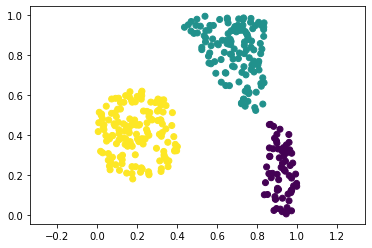

In [48]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

In [49]:
nn = NeuralNetwork(
                    [
                        Linear(2, 10), 
                        Sigmoid(), 
                        Linear(10, 10), 
                        Sigmoid(), 
                        Linear(10, 3)
                    ])

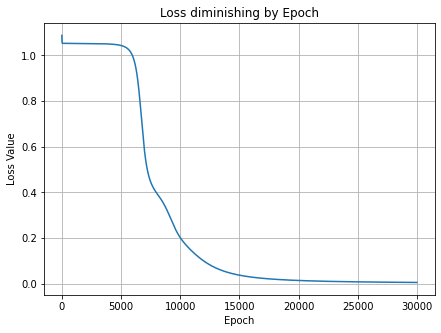

Minimal loss = 0.005574891657097513


In [50]:
NUM_EPOCHS = 30000
# Используем численную оптимизацию
loss_f = NLLLoss(mode="lse")

losses = []
# Производим обучение на всей выборке, батчи не используем
for epoch in range(NUM_EPOCHS):
    predictions = nn.forward(X)
    loss = loss_f.forward(predictions, y)
    losses.append(loss)
    dLdy = loss_f.backward()
    nn.backward(dLdy)
    # Делаем шаг в сторону антиградиента. Варьируем
    nn.step(0.05)

    
plt.figure(figsize=(7, 5))
plt.plot(losses)
plt.title("Loss diminishing by Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss Value")
plt.grid(True)
plt.show()
print(f"Minimal loss = {losses[-1]}")

In [51]:
predictions

array([[-13.27445405,   2.81606984,  10.31939237],
       [-13.7379943 ,   2.65229184,  10.94595613],
       [-14.17100745,   2.54508732,  11.48351828],
       ...,
       [-13.84353741,   2.65120263,  11.05067199],
       [  8.86600344,   2.63338983, -11.46876507],
       [  0.72591712,   4.72329853,  -5.48136206]])

In [52]:
y

array([2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 1, 2, 0, 0, 2, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 1, 0, 2, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 2, 2, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       2, 1, 0, 1, 1, 1, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0, 2, 2, 2,
       2, 2, 1, 1, 1, 0, 2, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 1, 0, 2,
       2, 1, 2, 2, 0, 2, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2,
       2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 1, 2, 1, 2, 0, 1, 1, 1, 2, 0, 2, 1, 1, 1, 2,
       2, 2, 0, 2, 0, 2, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 2,
       2, 1, 1, 1, 2, 1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 2, 2,
       1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 2, 2, 0, 1, 2,
       1, 1, 2, 2, 1, 0, 1, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 1, 2, 0, 1, 1,
       1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 2,

In [53]:
np.argmax(predictions, axis=1)

array([2, 2, 2, 1, 0, 2, 2, 2, 2, 0, 1, 2, 0, 0, 2, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 2, 2, 1, 1, 0, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 1, 2, 1, 1, 1, 0, 2, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 2, 2, 2, 1, 0, 1, 2, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2,
       2, 1, 0, 1, 1, 1, 1, 0, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0, 2, 2, 2,
       2, 2, 1, 1, 1, 0, 2, 1, 0, 2, 2, 2, 0, 2, 2, 1, 2, 1, 2, 1, 0, 2,
       2, 1, 2, 2, 0, 2, 1, 2, 1, 1, 1, 2, 2, 2, 0, 1, 2, 1, 2, 1, 0, 2,
       2, 1, 1, 2, 2, 2, 2, 1, 1, 2, 2, 0, 0, 2, 1, 1, 1, 2, 2, 2, 2, 0,
       2, 0, 2, 0, 2, 0, 2, 1, 2, 1, 2, 0, 1, 1, 1, 2, 0, 2, 1, 1, 1, 2,
       2, 2, 0, 2, 0, 2, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 2, 1, 1, 2, 1, 2,
       2, 1, 1, 1, 2, 1, 1, 0, 2, 0, 0, 1, 1, 2, 1, 2, 0, 1, 0, 2, 2, 2,
       1, 0, 2, 1, 2, 2, 1, 0, 0, 2, 1, 1, 1, 0, 1, 2, 0, 2, 2, 0, 1, 2,
       1, 1, 2, 2, 1, 0, 1, 2, 0, 0, 1, 2, 2, 2, 2, 1, 2, 1, 2, 0, 1, 1,
       1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 2, 2,

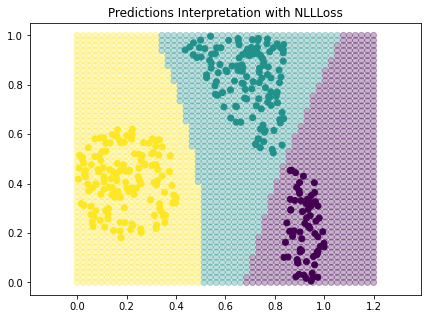

In [54]:
N_mesh = 50
x_grid = np.linspace(0.0, 1.2, N_mesh)
y_grid = np.linspace(0, 1, N_mesh)

# Разобьем пространство объектов на батчи
X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)

mesh = np.dstack((X_mesh, Y_mesh)).reshape(N_mesh * N_mesh, 2)
# Нейросеть с neglogsoftmax() возвращает вероятности принадлежности классу. Преобразуем в метки
predictions = np.argmax(nn.forward(mesh), 1)

plt.figure(figsize=(7, 5))
plt.title("Predictions Interpretation with NLLLoss")
plt.scatter(mesh[:, 0], mesh[:, 1], c=predictions, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

Обучите архитектуру вида 2 -> 10 -> 10 -> 3:
* Linear(2, 10)
* Sigmoid()
* Linear(10, 10)
* Sigmoid()
* Linear(10, 3)

В качестве функции потерь используйте NLLLoss.
1. Создайте сеть, в цикле запускайте forward, backward, step (используйте learning rate 0.005). 
2. Нарисуйте график сходимости (величина NLL после каждого обновления).
3. Нарисуйте разделяющую поверхность
4. Попробуйте подобрать темп обучения. Как меняется сходимость?  
__При выборе темпа обучения в 0,05, на 30000 эпохе потери сводятся практически к нулю__

Отличная визуализация: http://playground.tensorflow.org/

## Домашнее задание:

* Подберите темп обучения. Как меняется сходимость? Нарисуйте график оптимального значения функции потерь для различных значений learning_rate
* Решите поставленную выше задачу как задачу регрессии с MSE. Изменилась ли разделяющая поверхность?

In [55]:
class MSELoss:
    def __init__(self):
        pass
    
    def forward(self, X, y):
        '''
        Passes objects through this layer.
        X is np.array of size (N, C), where C is the number of classes
        y is np.array of size (N), contains correct labels
        '''
        self.X = X
        self.y = y.reshape(y.shape[0],-1)
        return np.sum((self.X - self.y) ** 2) / self.X.shape[0]
    
    def backward(self):
        '''
        Note that here dLdy = 1 since L = y
        1. Compute dLdx
        2. Return dLdx
        '''
        dLdx = 2 * (self.X - self.y) / self.y.shape[0]
        return dLdx

In [56]:
rates = np.linspace(0.005, 0.05, 20)
losses = []
network = NeuralNetwork(
                        [Linear(2, 10), 
                         Sigmoid(), 
                         Linear(10, 10), 
                         Sigmoid(), 
                         Linear(10, 3)
                        ])

for rate in rates:
    loss_f = MSELoss()
    for epoch in range(NUM_EPOCHS):
        predictions = network.forward(X)
        loss = loss_f.forward(predictions, y)
        dLdy = loss_f.backward()
        network.backward(dLdy)
        network.step(rate)
    losses.append(loss)

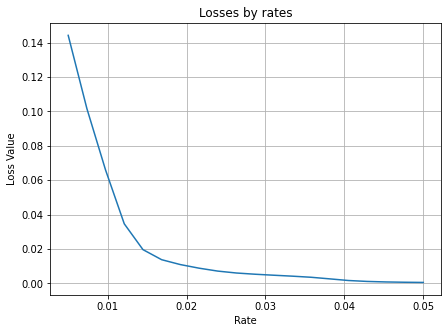

Minimal loss = 0.0006036883246385281


In [57]:
plt.figure(figsize=(7, 5))
plt.plot(rates, losses)
plt.title("Losses by rates")
plt.xlabel("Rate")
plt.ylabel("Loss Value")
plt.grid(True)
plt.show()
print(f"Minimal loss = {losses[-1]}")

In [58]:
network.forward(mesh)

array([[1.91795918, 1.91526158, 1.91556377],
       [1.88082818, 1.87784593, 1.87822416],
       [1.82231693, 1.81898693, 1.81938084],
       ...,
       [1.06617659, 1.06559917, 1.06537068],
       [1.0721356 , 1.07153381, 1.07132099],
       [1.07885707, 1.07822553, 1.07803591]])

In [59]:
np.argmax(network.forward(mesh), 1)

array([0, 0, 0, ..., 0, 0, 0])

In [60]:
(np.rint(network.forward(mesh)))[:, 0]

array([2., 2., 2., ..., 1., 1., 1.])

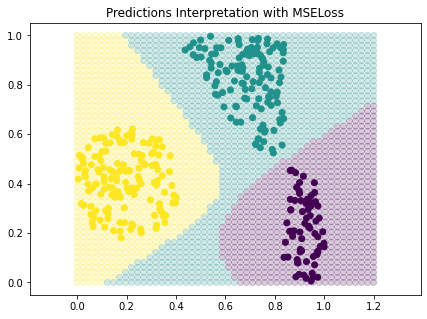

In [61]:
N_mesh = 50
x_grid = np.linspace(0, 1.2, N_mesh)
y_grid = np.linspace(0, 1, N_mesh)

X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)

mesh = np.dstack((X_mesh, Y_mesh)).reshape(N_mesh * N_mesh, 2)
# Так как работаем уже не с вероятностями, а простой метрикой, будем округлять до ближайшего целого числа
predictions = (np.rint(network.forward(mesh)))[:, 0]


plt.figure(figsize=(7, 5))
plt.title("Predictions Interpretation with MSELoss")
plt.scatter(mesh[:, 0], mesh[:, 1], c=predictions, alpha=0.2)
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()